##### Objectius:
- Arbres de classificació
- KNN - k-Nearest Neighbors
- Regressió Logística
- Support Vector Machine
- XGboost

Anem a practicar i a familiaritzar-nos amb algoritmes de classificació.

### Nivell 1 


#### - Exercici 1
Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).  

### Nivell 3  
(incorporat a tota la tasca)

#### - Exercici 6
No utilitzis la variable DepDelay a l’hora de fer prediccions

### Introducció  

Farem tots els exercicis però els executarem en un ordre diferent. Si deixéssim la variable DepDelay, o fins i tot eliminant DepDelay però deixant la resta de variables altament relacionades amb ArrDelay i DepDelay, tindriem unes prediccions gairebé perfectes, 'massa bones per ser reals'. Per aquest motiu, hem decidit treballar sense DepDeplay des del principi, per tenir una sensació més pròxima a un problema real.  

Començarem amb l'objectiu de predir quins vols arriben endarrerits i quins a l'hora programada ('On Time'). Un vol es considera 'On Time' si arriba menys de 15 minuts tard de l'hora progrmada (CRS). Així els dividirem en dos classes:

- No Delayed (on time)  = Arrival Delay < 15 min. 
- Delayed = Arrival Delay > 15 min. 

Per fer-ho farem servir diferents algoritmes que compararem inicialment sense fer Hyperparameter tunning ni massa enginyeria de variables. Més endavant treballarem amb altres divisions dels endarreriments, imbalanced data tot comparant la performance dels diferents algoritmes de classificació.


In [1]:
# Llibreries per la tasca

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import model_selection
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pandas_profiling import ProfileReport

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('DelayedFlights.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936758 entries, 0 to 1936757
Data columns (total 30 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   Year               int64  
 2   Month              int64  
 3   DayofMonth         int64  
 4   DayOfWeek          int64  
 5   DepTime            float64
 6   CRSDepTime         int64  
 7   ArrTime            float64
 8   CRSArrTime         int64  
 9   UniqueCarrier      object 
 10  FlightNum          int64  
 11  TailNum            object 
 12  ActualElapsedTime  float64
 13  CRSElapsedTime     float64
 14  AirTime            float64
 15  ArrDelay           float64
 16  DepDelay           float64
 17  Origin             object 
 18  Dest               object 
 19  Distance           int64  
 20  TaxiIn             float64
 21  TaxiOut            float64
 22  Cancelled          int64  
 23  CancellationCode   object 
 24  Diverted           int64  
 25  CarrierDelay      

In [4]:
df.head()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


Fent un simple .head() del dataset podem observar la relació problemàtica entre certes variables. La variable 'ArrDelay' és el resultat de la sostracció entre l'hora real d'arribada ('ArrTime') i l'hora programada d'arribada ('CRSArrTime'). El mateix passa amb 'DepDelay', 'DepTime' i 'CRSDepTime'. 

- Hem de tenir en compte que al tenir les dades temporals en format int (2211 en comptes de 22:11) la resta no queda bé en tots els casos. Per què quedés bé s'hauria de fer en base 24 per les hores i 60 pels minuts, en comptes de 10 (que és el mètode per defecte de python).

In [5]:
df[['CRSArrTime', 'ArrTime', 'ArrDelay']]

,CRSArrTime,ArrTime,ArrDelay
0,2225,2211.0,-14.0
1,1000,1002.0,2.0
2,750,804.0,14.0
3,1925,1959.0,34.0
4,2110,2121.0,11.0
...,...,...,...
1936753,1552,1617.0,25.0
1936754,749,904.0,75.0
1936755,1010,1149.0,99.0
1936756,1437,1446.0,9.0


Els valors de CRSArrTime menors que 10, com per exemple '5', vol dir que són les 00:05. Com veiem a la primera fila tenim un CRSArrTime programat per les 00.05, però l'hora d'arribada real és la 01:08 i com indica la columna ArrDelay, hi ha un enderreriment de 63 minuts respecte l'hora programada.

In [6]:
df[['CRSArrTime', 'ArrTime', 'ArrDelay']][df['CRSArrTime'] == 5]

,CRSArrTime,ArrTime,ArrDelay
79,5,108.0,63.0
119,5,31.0,26.0
189,5,36.0,31.0
503,5,115.0,70.0
1411,5,36.0,31.0
...,...,...,...
1926800,5,22.0,17.0
1926863,5,24.0,19.0
1927273,5,29.0,24.0
1927321,5,53.0,48.0


Per acabar-ho de confirmar creem la nosta pròpia variable 'ArrDelay' a partir de les variables ArrTime i CRSArrTime i la comparem a l'original:

In [7]:
df['ArrivalDelay'] = df['ArrTime'] - df['CRSArrTime']

La variable original i fabricada no coincideixen en tots els registres pel mateix tema del format de les dades temporals que hem comentat anteriorment, però agafem la idea de que són iguals.

In [8]:
df_arrd=pd.DataFrame({'ArrDelayOriginal':df['ArrDelay'], 'ArrDelayFabricada':df['ArrivalDelay']})
df_arrd

,ArrDelayOriginal,ArrDelayFabricada
0,-14.0,-14.0
1,2.0,2.0
2,14.0,54.0
3,34.0,34.0
4,11.0,11.0
...,...,...
1936753,25.0,65.0
1936754,75.0,155.0
1936755,99.0,139.0
1936756,9.0,9.0


#### Examen de colinealitat (corr) 

En el primer experiment amb les dades treiem les variables categòriques per poder fer ràpidament els primers models. Més endavant les recuperarem i examinarem el seu valor en la millora respecte els models anteriors:

In [9]:
df_1 = df
df_1.drop(['Unnamed: 0','Year','UniqueCarrier',
         'CancellationCode', 'Origin', 'Dest', 'TailNum' ], axis=1, inplace=True)

Imputem els null values a partir de la mediana, de la mateixa manera que hem fet amb l'exercici de regressió lineal, per ser el mètode d'imputació que menys augmentava la diferència de correlació entre variables.

In [10]:
for i in df_1.columns:
    df_1[i].fillna(df_1[i].median(), inplace = True)

In [11]:
corr = df_1[df_1.columns[1:]].corr()['ArrDelay'][:]

In [12]:
corr

DayofMonth           0.004068
DayOfWeek            0.006136
DepTime              0.126781
CRSDepTime           0.044521
ArrTime             -0.051065
CRSArrTime           0.042955
FlightNum            0.061117
ActualElapsedTime    0.068439
CRSElapsedTime      -0.016079
AirTime              0.000181
ArrDelay             1.000000
DepDelay             0.947660
Distance            -0.030161
TaxiIn               0.156104
TaxiOut              0.284920
Cancelled           -0.005781
Diverted            -0.020272
CarrierDelay         0.535340
WeatherDelay         0.277861
NASDelay             0.437473
SecurityDelay        0.011215
LateAircraftDelay    0.519247
ArrivalDelay        -0.106974
Name: ArrDelay, dtype: float64

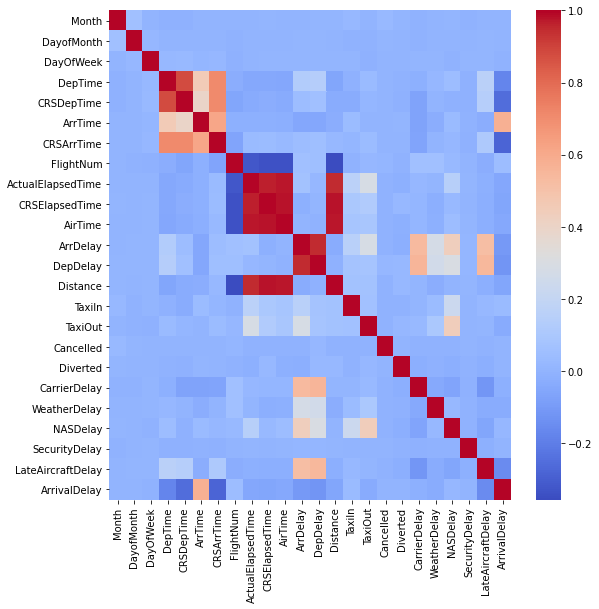

In [13]:
corr = df_1.corr() # train is a pandas dataframe 

plt.figure(figsize = (9, 9))
heatmap(corr, cmap = 'coolwarm')
plt.show()

####  Multicolinealitat (VIF)

Estudiem la multicolinealitat de les variables a partir del VIF, de la mateixa manera en que ho hem fet a la tasca de Regressió Lineal.

In [14]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [15]:
X = df_1.iloc[:,:-1]
round(calc_vif(X),3)

,variables,VIF
0,Month,3.839
1,DayofMonth,3.945
2,DayOfWeek,4.549
3,DepTime,64.100
4,CRSDepTime,63.861
5,ArrTime,16.077
6,CRSArrTime,38.608
7,FlightNum,2.453
8,ActualElapsedTime,13451.804
9,CRSElapsedTime,504.875


A banda de DepDelay, eliminem una de les dues variables que com hem vist la conformen, per evitar que la resposta de les prediccions estigui continguda en els features (fem el mateix per ArrDelay):  
- 'ArrTime'
- 'DepTime'  

De la mateixa manera eliminem les variables de 'motius d'enderreriment', que sumades entre elles donen els mateixos valors que Arrival Delay, amb l'única diferència que només queden registrades a partir dels 15 minuts d'endarreriment del vol: 
- 'CarrierDelay'
- 'WeatherDelay'
- 'NASDelay'
- 'SecurityDelay'
- 'LateAircraftDelay'  

Ens desfem d'AirTime, 'TaxiIn' i 'TaxiOut', que sumades donen 'ActualElapsedTime'. I també treiem 'ActualElapsedTime' i ens quedem amb 'CRSElapsedTime', perque restades donen la suma d'ArrDelay i DepDelay.
- 'AirTime
- 'TaxiIn'
- 'TaxiOut'
- 'ActualElapsedTime'


In [16]:
df_1.drop(['DepDelay', 'ArrTime', 'DepTime', 
           'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
            'AirTime', 'TaxiIn','TaxiOut', 'ActualElapsedTime'], axis=1, inplace=True)

In [17]:
X = df_1.iloc[:,:-1]
round(calc_vif(X),3)

,variables,VIF
0,Month,3.806
1,DayofMonth,3.927
2,DayOfWeek,4.508
3,CRSDepTime,24.450
4,CRSArrTime,26.529
5,FlightNum,2.419
6,CRSElapsedTime,104.296
7,ArrDelay,1.566
8,Distance,69.211
9,Cancelled,1.001


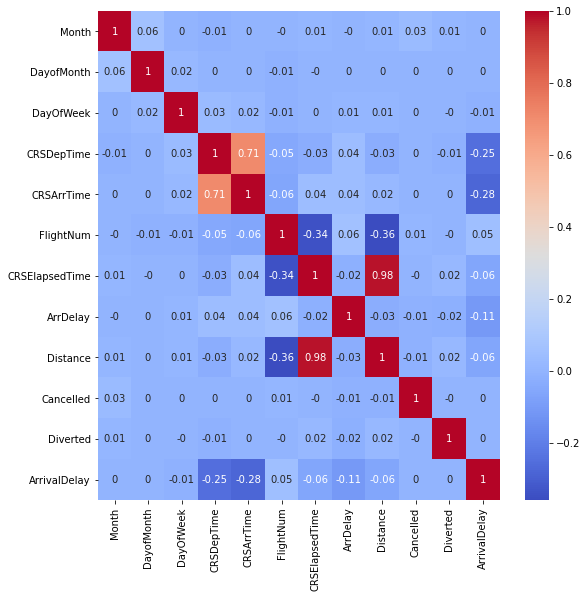

In [18]:
corr = round(df_1.corr(),2) # train is a pandas dataframe 

plt.figure(figsize = (9, 9))
heatmap(corr, annot=True, cmap = 'coolwarm')
plt.show()

#### Definició del target i les classes

In [19]:
max(df_1['ArrDelay'])

2461.0

Creem la variable Delayed a partir dels vols endarrerits més de quina minuts, de la variable 'ArrDelay':

In [20]:
cut_bins = min(df_1['ArrDelay']), 15, max(df_1['ArrDelay'])
df_1['Delayed'] = pd.cut(df_1['ArrDelay'], bins=cut_bins)

In [21]:
# Veiem la divisio del pd.cut. Tenim 2 bins
df_1['Delayed'].value_counts()

(15.0, 2461.0]    1223399
(-109.0, 15.0]     713358
Name: Delayed, dtype: int64

In [22]:
df_1['Delayed'].value_counts(normalize=True)

(15.0, 2461.0]    0.631674
(-109.0, 15.0]    0.368326
Name: Delayed, dtype: float64

El temps d'arrivada (enderreriment) queda dividit així en 2 grups o classes:  

- Entre -109.001 i 15.0 min       
- Entre 15.0 i 2461.0 min    

In [23]:
encoder = LabelEncoder()
df_1['Delayed'] = encoder.fit_transform(df_1['Delayed'])

df_1.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,Distance,Cancelled,Diverted,ArrivalDelay,Delayed
0,1,3,4,1955,2225,335,150.0,-14.0,810,0,0,-14.0,0
1,1,3,4,735,1000,3231,145.0,2.0,810,0,0,2.0,0
2,1,3,4,620,750,448,90.0,14.0,515,0,0,54.0,0
3,1,3,4,1755,1925,3920,90.0,34.0,515,0,0,34.0,1
4,1,3,4,1915,2110,378,115.0,11.0,688,0,0,11.0,0


In [24]:
df_1['Delayed'].value_counts()

1    1223399
0     713358
2          1
Name: Delayed, dtype: int64

Eliminem aquest registre on s'ha creat una classe de més per accident

In [25]:
i = df_1[df_1['Delayed'] == 2].index

In [26]:
df_1.drop(i, inplace = True)

### Classes

- 0 On Time (not delayed)  = Arrival Delay < 15 min. 
- 1 Delayed = Arrival Delay > 15 min.

In [27]:
df_1['Delayed'].value_counts(ascending=True)

0     713358
1    1223399
Name: Delayed, dtype: int64

Eliminem la columna ArrDelay ara que ja hem creat les classes

In [28]:
df_1.drop(['ArrDelay', 'ArrivalDelay'], axis = 1, inplace = True)

In [29]:
df_1.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,Distance,Cancelled,Diverted,Delayed
0,1,3,4,1955,2225,335,150.0,810,0,0,0
1,1,3,4,735,1000,3231,145.0,810,0,0,0
2,1,3,4,620,750,448,90.0,515,0,0,0
3,1,3,4,1755,1925,3920,90.0,515,0,0,1
4,1,3,4,1915,2110,378,115.0,688,0,0,0


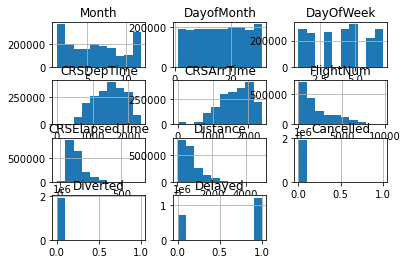

In [30]:
df_1.hist()
plt.show()

#### Mostra i divisió en train i test

In [31]:
forecast_col ='Delayed'

In [32]:
df_1['Delayed'].value_counts(normalize=True)

1    0.631674
0    0.368326
Name: Delayed, dtype: float64

Agafem una mostra estratificada de només 20000 observacions pel cost computacional que suposa pels diferents algoritmes. Com que hi ha moltes més de 10000 observacions de cada classe, ens queda una mostra balancejada.

In [33]:
df_sample= df_1.groupby('Delayed', group_keys=False).apply(lambda x: x.sample(10000, random_state = 0))

In [34]:
# Ens assegurem que la mostra respongui de manera corresponent a la proporció entre les classes:

df_sample['Delayed'].value_counts()

0    10000
1    10000
Name: Delayed, dtype: int64

In [35]:
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

Random Forest

In [36]:
rf = RandomForestClassifier()

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
rf_pred = rf.predict(X_test)

In [39]:
df_rf=pd.DataFrame({'Actual':y_test, 'Predicted':rf_pred})
df_rf

,Actual,Predicted
0,1,0
1,1,1
2,0,0
3,0,1
4,0,1
...,...,...
3995,0,1
3996,0,0
3997,0,0
3998,0,0


In [40]:
score_rf = metrics.accuracy_score(y_test, rf_pred)
print(score_rf)

0.561


Classification Tree 

In [41]:
ct = DecisionTreeClassifier()

In [42]:
ct = ct.fit(X_train,y_train)

In [43]:
ct_pred = ct.predict(X_test)

In [44]:
df_ct=pd.DataFrame({'Actual':y_test, 'Predicted':ct_pred})
df_ct

,Actual,Predicted
0,1,1
1,1,0
2,0,0
3,0,0
4,0,1
...,...,...
3995,0,1
3996,0,1
3997,0,0
3998,0,1


In [45]:
score_ct = metrics.accuracy_score(y_test, ct_pred)
print(score_ct)

0.53325


 XGBoost 

In [46]:
xgb_clf = xgb.XGBClassifier()

In [47]:
xgb_clf.fit(X_train,y_train)

[18:10:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
xgb_pred = xgb_clf.predict(X_test)

In [49]:
df_xgb=pd.DataFrame({'Actual':y_test, 'Predicted':xgb_pred})
df_xgb

,Actual,Predicted
0,1,0
1,1,0
2,0,0
3,0,1
4,0,1
...,...,...
3995,0,1
3996,0,1
3997,0,0
3998,0,0


In [50]:
print("Accuracy:",metrics.accuracy_score(y_test, xgb_pred))

Accuracy: 0.5575


K-Nearest Neighbours

In [51]:
knn = KNeighborsClassifier()

In [52]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [53]:
knn_pred = knn.predict(X_test)

In [54]:
df_knn=pd.DataFrame({'Actual':y_test, 'Predicted':knn_pred})
df_knn

,Actual,Predicted
0,1,0
1,1,1
2,0,0
3,0,1
4,0,1
...,...,...
3995,0,0
3996,0,0
3997,0,1
3998,0,1


In [55]:
score_knn = metrics.accuracy_score(y_test, knn_pred)
print(score_knn)

0.531


Logistic Regression 

In [56]:
logisticRegr = LogisticRegression()

In [57]:
logisticRegr.fit(X_train, y_train)

LogisticRegression()

In [58]:
lr_pred = logisticRegr.predict(X_test)

In [59]:
df_lr=pd.DataFrame({'Actual':y_test, 'Predicted':lr_pred})
df_lr

,Actual,Predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,0,1
...,...,...
3995,0,1
3996,0,1
3997,0,0
3998,0,1


In [60]:
score_lr = metrics.accuracy_score(y_test, lr_pred)
print(score_lr)

0.55575


Support Vector Machine (SVM) 

In [61]:
svm_clf= svm.SVC(kernel='linear')

In [62]:
svm_clf.fit(X_train, y_train)

SVC(kernel='linear')

In [63]:
svm_pred = svm_clf.predict(X_test)

In [64]:
df_svm=pd.DataFrame({'Actual':y_test, 'Predicted':svm_pred})
df_svm

,Actual,Predicted
0,1,1
1,1,1
2,0,0
3,0,0
4,0,1
...,...,...
3995,0,1
3996,0,1
3997,0,0
3998,0,1


In [65]:
print("Accuracy:",metrics.accuracy_score(y_test, svm_pred))

Accuracy: 0.555


#### Extra: comparació algoritmes automatitzada i visualització

In [66]:
# Automatitzar:

models = [('RForest', RandomForestClassifier()), 
          ('DecTree', DecisionTreeClassifier()),
          ('XGBoost', xgb.XGBClassifier(verbosity = 0)),
          ('KNN', KNeighborsClassifier()),
          ('LogisticReg', LogisticRegression()),
          ('GaussianNB', GaussianNB()) #Afegim el Gaussian Naive-Bayes i treiem el SVM.
         ]

scoring = 'accuracy'
# scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']

In [67]:
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    

RForest: 0.549875 (0.013529)
DecTree: 0.524312 (0.012548)
XGBoost: 0.552875 (0.011009)
KNN: 0.527375 (0.011190)
LogisticReg: 0.542063 (0.016071)
GaussianNB: 0.503688 (0.012458)


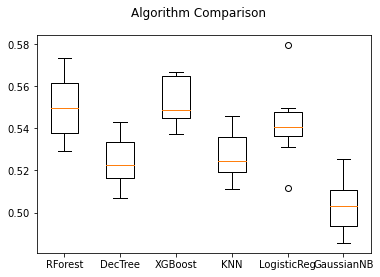

In [68]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### - Exercici 2
Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

In [69]:
print('La null accuracy és igual a:',max(y_test.mean(), 1 - y_test.mean()))

La null accuracy és igual a: 0.5


Això significa que un 'dumb model' predirà correctament la resposta un 50% de les vegades.

Random Forest

In [70]:
confusion = metrics.confusion_matrix(y_test, rf_pred)
print(confusion)

[[1136  864]
 [ 892 1108]]


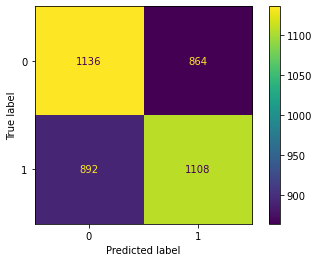

In [71]:
plot_confusion_matrix(rf, X_test, y_test)  
plt.show()  

- 0 = On Time
- 1 = Delayed  

Veiem una gran quantitat de  falsos negatius (FN), l'algoritme prediu que els vols arribaran tard quan arriben puntuals (864); i falsos positius (FP), 892 (els més baixos) on els vols arriben tard i es diu que arribaran a l'hora. La suma de FP i FN en aquest test és de 2000.

In [72]:
print(classification_report(y_test, rf_pred ))

              precision    recall  f1-score   support

           0       0.56      0.57      0.56      2000
           1       0.56      0.55      0.56      2000

    accuracy                           0.56      4000
   macro avg       0.56      0.56      0.56      4000
weighted avg       0.56      0.56      0.56      4000



In [73]:
print("L'accuraccy del random forest = ", score_rf)

L'accuraccy del random forest =  0.561


In [74]:
print("L'f1 score del randfom forest = ",round(f1_score(y_test, rf_pred, average = 'weighted'),3))

L'f1 score del randfom forest =  0.561


In [75]:
print("El recall score del randfom forest = ",round(recall_score(y_test, rf_pred, average = 'weighted'),3))

El recall score del randfom forest =  0.561


In [76]:
print("La precision_score score del randfom forest = ",round(metrics.precision_score(y_test, rf_pred, average = 'weighted'),3))

La precision_score score del randfom forest =  0.561


Classification Tree

In [77]:
print(confusion_matrix(y_test, ct_pred ))

[[1090  910]
 [ 957 1043]]


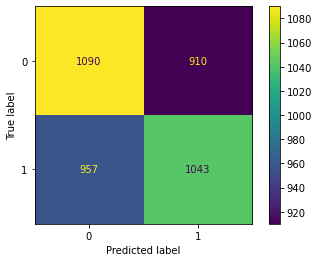

In [78]:
plot_confusion_matrix(ct, X_test, y_test)  
plt.show()  

En el Decision Tree els FN i FP augmenten (910) i (957) respectivament.

In [79]:
print(classification_report(y_test, ct_pred ))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54      2000
           1       0.53      0.52      0.53      2000

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.53      4000
weighted avg       0.53      0.53      0.53      4000



In [80]:
print("L'accuraccy del classification tree = ", score_ct)

L'accuraccy del classification tree =  0.53325


In [81]:
print("L'f1 score del classification tree = ",round(f1_score(y_test, ct_pred, average = 'weighted'),3))

L'f1 score del classification tree =  0.533


In [82]:
print("El recall score del classification tree = ",round(recall_score(y_test, ct_pred, average = 'weighted'),3))

El recall score del classification tree =  0.533


XGBoost

In [83]:
print(confusion_matrix(y_test, xgb_pred ))

[[1125  875]
 [ 895 1105]]


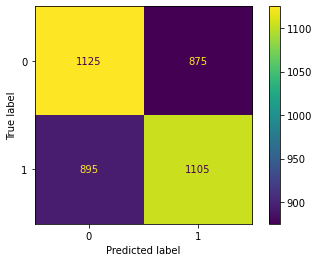

In [84]:
plot_confusion_matrix(xgb_clf, X_test, y_test)  
plt.show()  

L'XGBoost té millors resultats tan de FN com FP, 875 i 895 respectivament.

In [85]:
print(classification_report(y_test, xgb_pred ))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2000
           1       0.56      0.55      0.56      2000

    accuracy                           0.56      4000
   macro avg       0.56      0.56      0.56      4000
weighted avg       0.56      0.56      0.56      4000



In [86]:
print("L'accuracy de XGBoost:",metrics.accuracy_score(y_test, xgb_pred))

L'accuracy de XGBoost: 0.5575


In [87]:
print("L'f1 score del XGBoost = ",round(f1_score(y_test, xgb_pred, average = 'weighted'),3))

L'f1 score del XGBoost =  0.557


In [88]:
print("El recall score del XGBoost = ",round(recall_score(y_test, xgb_pred, average = 'weighted'),3))

El recall score del XGBoost =  0.558


K-Nearest Neighbours

In [89]:
print(confusion_matrix(y_test, knn_pred))

[[1053  947]
 [ 929 1071]]


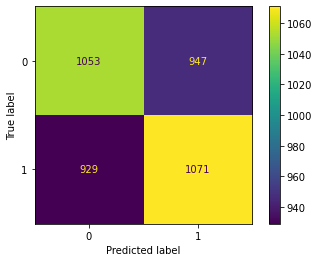

In [90]:
plot_confusion_matrix(knn, X_test, y_test)  
plt.show()  

Pel KNN els FN = 947 i els FP = 929.

In [91]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2000
           1       0.53      0.54      0.53      2000

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.53      4000
weighted avg       0.53      0.53      0.53      4000



In [92]:
print("L'accuraccy del K-Nearest Neighbors = ",score_knn)

L'accuraccy del K-Nearest Neighbors =  0.531


In [93]:
print("L'f1 score del K-Nearest Neighbors = ",round(f1_score(y_test, knn_pred, average = 'weighted'),3))

L'f1 score del K-Nearest Neighbors =  0.531


In [94]:
print("El recall score del K-Nearest Neighbors = ",round(recall_score(y_test, knn_pred, average = 'weighted'),3))

El recall score del K-Nearest Neighbors =  0.531


Logistic Regression

In [95]:
print(confusion_matrix(y_test, lr_pred))

[[1116  884]
 [ 893 1107]]


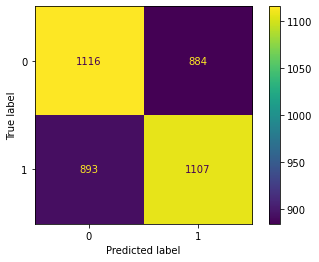

In [96]:
plot_confusion_matrix(logisticRegr, X_test, y_test)  
plt.show()  

Pel Logistic Regression els FN = 884 i els FP = 893.

In [97]:
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2000
           1       0.56      0.55      0.55      2000

    accuracy                           0.56      4000
   macro avg       0.56      0.56      0.56      4000
weighted avg       0.56      0.56      0.56      4000



In [98]:
print("L'accuraccy de Logistic Regression = ",score_lr)

L'accuraccy de Logistic Regression =  0.55575


In [99]:
print("L'f1 score de Logistic Regression = ",round(f1_score(y_test, lr_pred, average = 'weighted'),3))

L'f1 score de Logistic Regression =  0.556


In [100]:
print("El recall score de Logistic Regression = ",round(recall_score(y_test, lr_pred, average = 'weighted'),3))

El recall score de Logistic Regression =  0.556


Support Vector Machine (SVM)

In [101]:
print(confusion_matrix(y_test, svm_pred))

[[1198  802]
 [ 978 1022]]


Pel SVM els FN = 802 (els més baixos) i els FP = 978.

In [102]:
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           0       0.55      0.60      0.57      2000
           1       0.56      0.51      0.53      2000

    accuracy                           0.56      4000
   macro avg       0.56      0.55      0.55      4000
weighted avg       0.56      0.56      0.55      4000



In [103]:
print("Accuracy:",metrics.accuracy_score(y_test, svm_pred))

Accuracy: 0.555


In [104]:
print("L'f1 score del SVM = ",round(f1_score(y_test, svm_pred, average = 'weighted'),3))

L'f1 score del SVM =  0.554


In [105]:
print("El recall score del SVM = ",round(recall_score(y_test, svm_pred, average = 'weighted'),3))

El recall score del SVM =  0.555


IMPORTANT: les xifres de les mètriques podrien variar una mica en cada run i pot ser que les conclusions no estiguin exactament clavades.

Conclusions:
- De moment cap dels algoritmes emprats és clarament superior a un 'dumb model' que predís totes les observacions com a 'Delayed'. Després de fer una stratified sample la NULL ACCURACY és igual a 50% i amb prou feines hem superat aquesta mètrica, sent els models d'XGBoost, Randfom Forest i Logistic Regression els que millor han predit les classes, amb un 0.58 d'accuracy per un singular logistic regression en el k-fold cross_validation score.

- En termes de f1 score (que té en compte la sensitibity/recall i precision, els falsos positius i falsos negatius) els millors models es repeteixen amb a un F1 = 0.57.  

- Mirant les confusions matrix, el que té menys falsos negatius és l'SVM i falsos positius és el Random Forest, encara que proporcionalment segueixen sent molts.


### - Exercici 3: Hyperparameter Tunning
Entrena’ls utilitzant els diferents paràmetres que admeten.


#### Random Forest

##### n_estimators

Canviem el paràmetre n_estimators 9 cops en el rang de 1 a 200

In [106]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
m = []
for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators = n_estimator).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big) 
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.513, 0.51475, 0.53025, 0.536, 0.52975, 0.55525, 0.55, 0.5635, 0.555]
Max accuracy is 0.5635 in the index 7 of the iteration list


##### max_depths

Canviem el paràmetre max_depths 10 cops en el rang de 1 a 50

In [107]:
max_depths = np.linspace(1, 50, 10, endpoint=True)
m = []
for max_depth in max_depths:
    rf = RandomForestClassifier(max_depth = max_depth).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)   
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5425, 0.5555, 0.56075, 0.554, 0.5565, 0.5535, 0.564, 0.55625, 0.55975, 0.559]
Max accuracy is 0.564 in the index 6 of the iteration list


##### min_samples_splits

Canviem el paràmetre min_samples_leafs 10 cops en el rang de 0.1 a 1

In [108]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
m = []
for min_samples_split in min_samples_splits:
    rf = RandomForestClassifier(min_samples_split = min_samples_split).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big) 
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.54775, 0.54625, 0.54525, 0.5415, 0.54175, 0.53575, 0.5, 0.5, 0.5, 0.5]
Max accuracy is 0.54775 in the index 0 of the iteration list


##### min_samples_leafs

Canviem el paràmetre min_samples_leafs 10 cops en el rang de 0.1 a 0.5 

In [109]:
min_samples_leafs = np.linspace(0.1, 0.5, 10, endpoint=True)
m = []
for min_samples_leaf in min_samples_leafs:
    rf = RandomForestClassifier(min_samples_leaf = min_samples_leaf).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)   
print(m)
print(f"Max accuracy with min_samples_leaf is {big} in the {spot}th iteration")

[0.54925, 0.54475, 0.53575, 0.53925, 0.53125, 0.5, 0.5, 0.5, 0.5, 0.5]
Max accuracy with min_samples_leaf is 0.54925 in the 0th iteration


##### max_features

Canviem el paràmetre n_neighbors d'1 al total de features

In [110]:
max_features = list(range(1,df_sample.shape[1]))
m = []
for max_feature in max_features:
    rf = RandomForestClassifier(max_features = max_feature).fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy with max_features is {big} in the {spot}th iteration")

[0.56075, 0.55625, 0.554, 0.5535, 0.5605, 0.557, 0.55075, 0.54925, 0.5515, 0.55825]
Max accuracy with max_features is 0.56075 in the 0th iteration


#### Decision Tree Classifier

##### max_depths

Canviem el paràmetre max_depths 50 cops en el rang de 1 a 50

In [111]:
max_depths = np.linspace(1, 50, 50, endpoint=True)
m = []
for max_depth in max_depths:
    ct = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)
    y_pred = ct.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big) 
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.529, 0.5335, 0.54375, 0.555, 0.56, 0.5545, 0.55275, 0.5435, 0.54325, 0.531, 0.5295, 0.53225, 0.53625, 0.527, 0.52875, 0.532, 0.537, 0.53625, 0.52875, 0.537, 0.535, 0.5255, 0.52725, 0.526, 0.53, 0.523, 0.52325, 0.53275, 0.53025, 0.52725, 0.5355, 0.524, 0.52775, 0.5325, 0.5325, 0.52975, 0.5315, 0.53, 0.53075, 0.53125, 0.5375, 0.532, 0.52525, 0.531, 0.5345, 0.53275, 0.53125, 0.53625, 0.53075, 0.52725]
Max accuracy is 0.56 in the index 4 of the iteration list


##### min_samples_splits

Canviem el paràmetre min_samples_leafs 20 cops en el rang de 0.0001 a 1

In [112]:
min_samples_splits = np.linspace(0.0001, 1.0, 20, endpoint=True)
m = []
for min_samples_split in min_samples_splits:
    ct = DecisionTreeClassifier(min_samples_split = min_samples_split).fit(X_train, y_train)
    y_pred = ct.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.53725, 0.53125, 0.5315, 0.543, 0.54625, 0.5485, 0.54525, 0.5465, 0.5465, 0.5335, 0.5335, 0.5335, 0.5335, 0.5335, 0.5335, 0.5335, 0.529, 0.529, 0.529, 0.529]
Max accuracy is 0.5485 in the index 5 of the iteration list


##### min_samples_leafs

Canviem el paràmetre min_samples_leafs 20 cops en el rang de 0.001 a 0.5 

In [113]:
min_samples_leafs = np.linspace(0.001, 0.5, 20, endpoint=True)
m = []
for min_samples_leaf in min_samples_leafs:
    ct = DecisionTreeClassifier(min_samples_leaf = min_samples_leaf).fit(X_train, y_train)
    y_pred = ct.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5265, 0.54175, 0.54475, 0.5445, 0.5465, 0.5465, 0.5465, 0.54525, 0.53525, 0.53125, 0.52975, 0.529, 0.52175, 0.52175, 0.52175, 0.52175, 0.531, 0.531, 0.531, 0.5]
Max accuracy is 0.5465 in the index 4 of the iteration list


##### max_features

Canviem el paràmetre max_features d'1 al total de features

In [114]:
max_features = list(range(1,df_sample.shape[1]))
m = []
for max_feature in max_features:
    ct = DecisionTreeClassifier(max_features = max_feature).fit(X_train, y_train)
    y_pred = ct.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.52825, 0.53075, 0.515, 0.53125, 0.5285, 0.518, 0.5235, 0.525, 0.5325, 0.535]
Max accuracy is 0.535 in the index 9 of the iteration list


#### XGBoost

##### learning rates

In [115]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
m = []

for learning_rate in learning_rates:
    xgb_clf = xgb.XGBClassifier(learning_rate = learning_rate, verbosity = 0).fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)

big = max(m)
spot = m.index(big)   
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.51975, 0.552, 0.56225, 0.56175, 0.562, 0.559]
Max accuracy is 0.56225 in the index 2 of the iteration list


##### n_estimators

Canviem el paràmetre n_estimators 9 cops en el rang de 1 a 200

In [116]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
m = []

for n_estimator in n_estimators:
    xgb_clf = xgb.XGBClassifier(n_estimators = n_estimator, verbosity = 0).fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)

big = max(m)
spot = m.index(big)   
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.55125, 0.55675, 0.5495, 0.56225, 0.55925, 0.56275, 0.55825, 0.5575, 0.5515]
Max accuracy is 0.56275 in the index 5 of the iteration list


##### max_depths

Canviem el paràmetre max_depths 11 cops en el rang de 1 a 50

In [117]:
max_depths = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
m = []
for max_depth in max_depths:
    xgb_clf = xgb.XGBClassifier(max_depth = max_depth).fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.54225, 0.55725, 0.55975, 0.55675, 0.54325, 0.555, 0.55725, 0.55025, 0.557, 0.552, 0.55275]
Max accuracy is 0.55975 in the index 2 of the iteration list


##### min_samples_splits

Canviem el paràmetre min_samples_leafs 10 cops en el rang de 0.01 a 1

In [118]:
min_samples_splits = np.linspace(0.01, 1.0, 10, endpoint=True)
m = []
for min_samples_split in min_samples_splits:
    xgb_clf = xgb.XGBClassifier(min_samples_split = min_samples_split, verbosity = 0).fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)   
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575]
Max accuracy is 0.5575 in the index 0 of the iteration list


##### min_samples_leafs

Canviem el paràmetre min_samples_leafs 10 cops en el rang de 0.001 a 0.5 

In [119]:
min_samples_leafs = np.linspace(0.001, 0.5, 10, endpoint=True)
m = []
for min_samples_leaf in min_samples_leafs:
    xgb_clf = xgb.XGBClassifier(min_samples_leaf = min_samples_leaf).fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)   
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575]
Max accuracy is 0.5575 in the index 0 of the iteration list


##### max_features

Canviem el paràmetre n_neighbors d'1 al total de features

In [120]:
max_features = list(range(1,df_sample.shape[1]))
m = []
for max_feature in max_features:
    xgb_clf = xgb.XGBClassifier(max_features = max_feature).fit(X_train, y_train)
    y_pred = xgb_clf.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)
    
big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575, 0.5575]
Max accuracy is 0.5575 in the index 0 of the iteration list


####  K-Nearest Neighbours

In [121]:
# Agafem un mostra més petita per agilitzar el parameter tunning dels següents algoritmes:

df_sample= df_1.groupby('Delayed', group_keys=False).apply(lambda x: x.sample(5000, random_state = 0))
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

##### n_neighbors

Canviem el paràmetre n_neighbors d'1 a 30

In [122]:
neighbors = list(range(1,30))
m = []

for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)

big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5125, 0.518, 0.5165, 0.5135, 0.5215, 0.5155, 0.5105, 0.507, 0.531, 0.5235, 0.525, 0.52, 0.5315, 0.5195, 0.522, 0.514, 0.5285, 0.5215, 0.529, 0.5345, 0.531, 0.53, 0.523, 0.5215, 0.5205, 0.5275, 0.5205, 0.5205, 0.518]
Max accuracy is 0.5345 in the index 19 of the iteration list


####  Logistic Regression

##### Solver

In [123]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
m = []

for solver in solvers:
    logisticRegr = LogisticRegression(solver = solver).fit(X_train, y_train)
    y_pred = logisticRegr.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)

big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5325, 0.5325, 0.5325, 0.5385, 0.5365]
Max accuracy is 0.5385 in the index 3 of the iteration list


##### Penalty

In [124]:
penaltys = ['none','l2']
m = []

for penalty in penaltys:
    logisticRegr = LogisticRegression(penalty = penalty).fit(X_train, y_train)
    y_pred = logisticRegr.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)

big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5325, 0.5325]
Max accuracy is 0.5325 in the index 0 of the iteration list


##### C

In [125]:
cs = [100, 10, 1.0, 0.1, 0.01]
m = []

for c in cs:
    logisticRegr = LogisticRegression(C = c).fit(X_train, y_train)
    y_pred = logisticRegr.predict(X_test)
    x = metrics.accuracy_score(y_test, y_pred)
    m.append(x)

big = max(m)
spot = m.index(big)  
print(m)
print(f"Max accuracy is {big} in the index {spot} of the iteration list")

[0.5325, 0.532, 0.5325, 0.536, 0.537]
Max accuracy is 0.537 in the index 4 of the iteration list


##### Extra: GridSearch CV  per logistic regression

In [126]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.542667 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.542333 (0.019905) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.542333 (0.019905) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.542333 (0.019905) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.542375 (0.019841) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.542333 (0.019769) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.542375 (0.019841) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.542250 (0.020040) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.542333 (0.020020) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.542292 (0.020024) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.542625 (0.020113) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.542667 (0.020046) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.542625 (0.020011) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.536542 (0.018646) with: {

#### Support Vector Machine (SVM)

##### kernels

In [127]:
kernels = ['linear', 'rbf', 'poly']
for kernel in kernels:
    svc = svm.SVC(kernel=kernel).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5335
Accuracy: 0.5295
Accuracy: 0.5225


##### gammas:

In [128]:
gammas = [0.1, 1, 10, 100]

for gamma in gammas:
    svc = svm.SVC(kernel='rbf', gamma=gamma).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5315
Accuracy: 0.5515
Accuracy: 0.5175
Accuracy: 0.504


##### C

In [129]:
cs = [0.1, 1, 10, 100, 1000]

for c in cs:
    svc = svm.SVC(kernel='rbf', C=c).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.532
Accuracy: 0.5295
Accuracy: 0.521
Accuracy: 0.5415
Accuracy: 0.5365


##### Degrees

In [130]:
degrees = [0, 1, 2, 3, 4, 5, 6]
for degree in degrees:
    svc = svm.SVC(kernel='poly', degree=degree).fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5
Accuracy: 0.5335
Accuracy: 0.5175
Accuracy: 0.5225
Accuracy: 0.5105
Accuracy: 0.5225
Accuracy: 0.5005


Conclusions: Hem vist els efectes que tenen els diferents hyperparàmetres de cada algoritme dels models que havíem provat en l'acuraccy de les seves prediccions. Per veure com interaccionen els canvis de cada hyperparàmetre entre ells hauríem de fer un GridSearchCV. Hem fet una prova amb el model de Logistic Regression i hauríem de seguir en aquest sentit però de moment ho deixem per més endavant.

### - Exercici 4: inner validation
Compara el seu rendiment utilitzant l’aproximació traint/test o utilitzant totes les dades (validació interna).


In [131]:
df_sample= df_1.groupby('Delayed', group_keys=False).apply(lambda x: x.sample(20000, random_state = 0))
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)

Random Forest sense train/test (validació interna)

In [132]:
rf = RandomForestClassifier()

In [133]:
rf.fit(X, y)

RandomForestClassifier()

In [134]:
rf_pred = rf.predict(X)

In [135]:
score_rf = metrics.accuracy_score(y, rf_pred)
print(score_rf)

1.0


In [136]:
print(classification_report(y, rf_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



Classification Tree sense train/test (validació interna)

In [137]:
ct = DecisionTreeClassifier()

In [138]:
ct = ct.fit(X,y)

In [139]:
ct_pred = ct.predict(X)

In [140]:
print(confusion_matrix(y, ct_pred ))

[[20000     0]
 [    0 20000]]


In [141]:
print(classification_report(y, ct_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20000
           1       1.00      1.00      1.00     20000

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



In [142]:
score_ct = ct.score(X, y)
print(score_ct)

1.0


XGBoost sense train/test (validació interna)

In [143]:
xgb_clf = xgb.XGBClassifier()

In [144]:
xgb_clf.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [145]:
xgb_pred = xgb_clf.predict(X)

In [146]:
print("Accuracy:",metrics.accuracy_score(y, xgb_pred))

Accuracy: 0.717975


In [147]:
print(confusion_matrix(y, xgb_pred ))

[[14733  5267]
 [ 6014 13986]]


K-Nearest Neighbours sense train/test (validació interna)

In [148]:
knn = KNeighborsClassifier(n_neighbors=5)

In [149]:
knn.fit(X, y)

KNeighborsClassifier()

In [150]:
knn_pred = knn.predict(X)

In [151]:
score_knn = knn.score(X, y)
print(score_knn)

0.7103


Logistic Regression sense train/test (validació interna)

In [152]:
logisticRegr = LogisticRegression()

In [153]:
logisticRegr.fit(X, y)

LogisticRegression()

In [154]:
lr_pred = logisticRegr.predict(X)

In [155]:
score = logisticRegr.score(X, y)
print(score)

0.547325


In [156]:
cm = metrics.confusion_matrix(y, lr_pred)
print(cm)

[[10768  9232]
 [ 8875 11125]]


Support Vector Machine (SVM) sense train/test (validació interna)

In [157]:
svm_clf= svm.SVC(kernel='linear') 

In [158]:
svm_clf.fit(X, y)

SVC(kernel='linear')

In [159]:
svm_pred = svm_clf.predict(X)

In [160]:
print("Accuracy:",metrics.accuracy_score(y, svm_pred))

Accuracy: 0.54605


In [161]:
print(confusion_matrix(y, svm_pred ))

[[10722  9278]
 [ 8880 11120]]


Conclusions: és interessant veure, mitjançant la validació interna, sense train i test, com actuen els models que hem escollit des del principi. Mentre que RandomForest i ClassificationTree tenen una accuracy d'1,  l'XGBoost i KNN ronden el 0.7 i els models de LogisticRegression i SVM, el 0.55.

- Al primer exercici hem realitzat una cross_val_score amb k-fold en cas que fos això el que demanava l'exercici i hem fet una comparació de l'accuracy dels diferents models, que es pot comparar amb els resultats del train test a l'exercici 2.

## Nivell 2


### - Exercici 5
Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

Al llarg de la tasca ja hem dut a terme algun procés d'enginyeria de variables, com el LabelEncoder per passar a binari les classes categòriques a predir; l'estanderització de les dades en tots els exercicis i la selecció de features al principi tenint en compte la correlació amb el target i la multiconlinealitat. Creiem que no té massa sentit intentar crear nous features quan ens hem esforçat en limitar les variables per tal que el problema fos el més similar al d'una situació real.

Primer recuperarem les variables categòriques que havíem eliminat al principi per veure quin pes tenen en la millora dels models inicials. Després provarem de canviar la manera com dividim els enderreriments perquè quedi imabalanced i practicar les estratègies d'upsampling, downsampling i SMOTE. Al final també provarem algun procés d'enginyeria de variable més clàssic, fent un PCA per l'algoritme de KNN i provarem de dividir els enderreriments en 4 classes en comptes de 2.

#### Recuperació de les variables categòriques

In [162]:
df = pd.read_csv('DelayedFlights.csv')
df

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,7009710,2008,12,13,6,1250.0,1220,1617.0,1552,DL,1621,N938DL,147.0,152.0,120.0,25.0,30.0,MSP,ATL,906,9.0,18.0,0,N,0,3.0,0.0,0.0,0.0,22.0
1936754,7009717,2008,12,13,6,657.0,600,904.0,749,DL,1631,N3743H,127.0,109.0,78.0,75.0,57.0,RIC,ATL,481,15.0,34.0,0,N,0,0.0,57.0,18.0,0.0,0.0
1936755,7009718,2008,12,13,6,1007.0,847,1149.0,1010,DL,1631,N909DA,162.0,143.0,122.0,99.0,80.0,ATL,IAH,689,8.0,32.0,0,N,0,1.0,0.0,19.0,0.0,79.0
1936756,7009726,2008,12,13,6,1251.0,1240,1446.0,1437,DL,1639,N646DL,115.0,117.0,89.0,9.0,11.0,IAD,ATL,533,13.0,13.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [163]:
df.head(5)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [164]:
df_1 = df
df_1.drop('Unnamed: 0', axis=1, inplace = True)

In [165]:
df_1

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936753,2008,12,13,6,1250.0,1220,1617.0,1552,DL,1621,N938DL,147.0,152.0,120.0,25.0,30.0,MSP,ATL,906,9.0,18.0,0,N,0,3.0,0.0,0.0,0.0,22.0
1936754,2008,12,13,6,657.0,600,904.0,749,DL,1631,N3743H,127.0,109.0,78.0,75.0,57.0,RIC,ATL,481,15.0,34.0,0,N,0,0.0,57.0,18.0,0.0,0.0
1936755,2008,12,13,6,1007.0,847,1149.0,1010,DL,1631,N909DA,162.0,143.0,122.0,99.0,80.0,ATL,IAH,689,8.0,32.0,0,N,0,1.0,0.0,19.0,0.0,79.0
1936756,2008,12,13,6,1251.0,1240,1446.0,1437,DL,1639,N646DL,115.0,117.0,89.0,9.0,11.0,IAD,ATL,533,13.0,13.0,0,N,0,NaN,NaN,NaN,NaN,NaN


Farem servir LabelEncoder per les variables categòriques que haviem eliminat al principi. Si féssim One Hot Encoding acabariem amb més de 600 columnes, cosa que volem evitar.

In [166]:
df_1['Origin'].value_counts(ascending=False)

ATL    131613
ORD    125979
DFW     95414
DEN     74323
LAX     58772
IAH     56847
PHX     55720
LAS     53710
EWR     52925
DTW     43923
SFO     43801
MCO     36139
CLT     35055
JFK     34706
MSP     32436
LGA     31185
SEA     31060
BWI     30710
PHL     30316
MDW     29222
SLC     28675
BOS     28196
SAN     24828
CVG     23881
MIA     23273
IAD     22125
TPA     20199
HOU     19639
FLL     19363
DAL     18710
MEM     18121
DCA     17725
STL     17328
OAK     17031
BNA     16496
CLE     16398
MCI     16022
RDU     15383
PDX     13791
SMF     13644
SJC     13082
MKE     11876
AUS     11843
SNA     11554
SAT     10902
PIT     10799
ABQ     10674
MSY     10498
IND      9710
HNL      8666
ONT      8646
CMH      8394
JAX      7933
PBI      7684
BUR      7259
BUF      6777
RSW      6602
BDL      6496
OMA      6423
RNO      6146
OKC      6114
BHM      6068
SJU      5918
SDF      5786
PVD      5694
TUL      5600
TUS      5531
ANC      5140
ELP      4828
RIC      4784
MHT      4686
LIT   

In [167]:
encoder = LabelEncoder()

df_1['Origin']= encoder.fit_transform(df_1['Origin'])

df_1.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,135,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,135,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,140,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,140,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,140,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [168]:
df_1['Origin'].value_counts(ascending=False)

18     131613
210    125979
81      95414
80      74323
157     58772
136     56847
220     55720
155     53710
96      52925
87      43923
259     43801
177     36139
63      35055
150     34706
199     32436
162     31185
258     31060
48      30710
219     30316
179     29222
267     28675
37      28196
249     24828
73      23881
186     23273
135     22125
285     20199
130     19639
104     19363
76      18710
181     18121
79      17725
275     17328
204     17031
35      16496
61      16398
175     16022
238     15383
216     13791
269     13644
264     13082
187     11876
20      11843
271     11554
250     10902
224     10799
2       10674
200     10498
140      9710
129      8666
209      8646
64       8394
149      7933
215      7684
47       7259
46       6777
248      6602
24       6496
207      6423
243      6146
206      6114
29       6068
266      5918
257      5786
233      5694
287      5600
289      5531
16       5140
91       4828
241      4784
185      4686
165   

In [169]:
df_1['Dest'].value_counts(ascending=False)

ORD    108984
ATL    106898
DFW     70657
DEN     63003
LAX     59969
EWR     55861
LAS     48858
PHX     47836
SFO     46876
IAH     43905
LGA     38137
MCO     36405
JFK     35506
DTW     34777
BOS     31961
SEA     31548
PHL     30795
BWI     29610
SLC     29217
MSP     28137
CLT     26898
SAN     26621
MDW     25318
IAD     22748
TPA     22665
FLL     20323
CVG     20056
DCA     19735
MIA     19706
STL     18582
OAK     18302
MCI     18205
CLE     17991
HOU     17712
RDU     17378
BNA     17338
PDX     16300
SMF     16007
MEM     15626
SJC     15577
AUS     15538
DAL     15179
SAT     14533
PIT     12487
ABQ     12183
SNA     12101
IND     11769
MSY     11706
MKE     10930
CMH     10780
ONT     10231
HNL     10095
JAX      9586
BDL      8905
OMA      8472
PBI      8463
OKC      8241
BUR      8185
BUF      7973
TUL      7777
TUS      7499
SJU      7464
BHM      7425
RSW      7316
RNO      7282
PVD      7212
SDF      6966
ELP      6587
ANC      6291
MHT      6010
RIC      5892
LIT   

In [170]:
encoder = LabelEncoder()

df_1['Dest']= encoder.fit_transform(df_1['Dest'])

df_1.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,135,286,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,135,286,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [171]:
df_1['Dest'].value_counts(ascending=False)

212    108984
18     106898
82      70657
81      63003
158     59969
97      55861
156     48858
222     47836
260     46876
137     43905
163     38137
178     36405
151     35506
88      34777
37      31961
259     31548
221     30795
48      29610
268     29217
200     28137
63      26898
250     26621
180     25318
136     22748
286     22665
105     20323
73      20056
80      19735
187     19706
276     18582
205     18302
176     18205
61      17991
131     17712
239     17378
35      17338
218     16300
270     16007
182     15626
265     15577
20      15538
77      15179
251     14533
226     12487
2       12183
272     12101
141     11769
201     11706
188     10930
64      10780
211     10231
130     10095
150      9586
24       8905
209      8472
217      8463
208      8241
47       8185
46       7973
288      7777
290      7499
267      7464
29       7425
249      7316
244      7282
234      7212
258      6966
92       6587
16       6291
186      6010
242      5892
166   

In [172]:
df_1['UniqueCarrier'].value_counts(ascending=False)

WN    377602
AA    191865
MQ    141920
UA    141426
OO    132433
DL    114238
XE    103663
CO    100195
US     98425
EV     81877
NW     79108
FL     71284
YV     67063
B6     55315
OH     52657
9E     51885
AS     39293
F9     28269
HA      7490
AQ       750
Name: UniqueCarrier, dtype: int64

In [173]:
encoder = LabelEncoder()

df_1['UniqueCarrier']= encoder.fit_transform(df_1['UniqueCarrier'])

df_1.head()


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,17,335,N712SW,128.0,150.0,116.0,-14.0,8.0,135,286,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,17,3231,N772SW,128.0,145.0,113.0,2.0,19.0,135,286,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,17,448,N428WN,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,17,3920,N464WN,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,17,378,N726SW,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


In [174]:
df_1['UniqueCarrier'].value_counts(ascending=False)

17    377602
1     191865
11    141920
15    141426
14    132433
6     114238
18    103663
5     100195
16     98425
7      81877
12     79108
9      71284
19     67063
4      55315
13     52657
0      51885
3      39293
8      28269
10      7490
2        750
Name: UniqueCarrier, dtype: int64

In [175]:
df_1['CancellationCode'].value_counts(ascending=False)

N    1936125
B        307
A        246
C         80
Name: CancellationCode, dtype: int64

In [176]:
encoder = LabelEncoder()

df_1['CancellationCode']= encoder.fit_transform(df_1['CancellationCode'])

df_1.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,17,335,N712SW,128.0,150.0,116.0,-14.0,8.0,135,286,810,4.0,8.0,0,3,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,17,3231,N772SW,128.0,145.0,113.0,2.0,19.0,135,286,810,5.0,10.0,0,3,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,17,448,N428WN,96.0,90.0,76.0,14.0,8.0,140,48,515,3.0,17.0,0,3,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,1829.0,1755,1959.0,1925,17,3920,N464WN,90.0,90.0,77.0,34.0,34.0,140,48,515,3.0,10.0,0,3,0,2.0,0.0,0.0,0.0,32.0
4,2008,1,3,4,1940.0,1915,2121.0,2110,17,378,N726SW,101.0,115.0,87.0,11.0,25.0,140,150,688,4.0,10.0,0,3,0,NaN,NaN,NaN,NaN,NaN


Eliminem les mateixes variables numèriques:

In [177]:
df_1.drop(['TailNum','Year', 'DepDelay', 'ArrTime', 'DepTime', 
           'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
            'AirTime', 'TaxiIn','TaxiOut', 'ActualElapsedTime'], axis=1, inplace = True)

Fem la mateixa imputació de null values:

In [178]:
for i in df_1.columns:
    df_1[i].fillna(df_1[i].median(), inplace = True)

I la mateixa divisió de classes

In [179]:
cut_bins = min(df_1['ArrDelay']), 15, max(df_1['ArrDelay'])
df_1['Delayed'] = pd.cut(df_1['ArrDelay'], bins=cut_bins)

In [180]:
df_1['Delayed'].value_counts()

(15.0, 2461.0]    1223399
(-109.0, 15.0]     713358
Name: Delayed, dtype: int64

In [181]:
df_1['Delayed'].value_counts(normalize=True)

(15.0, 2461.0]    0.631674
(-109.0, 15.0]    0.368326
Name: Delayed, dtype: float64

In [182]:
encoder = LabelEncoder()
df_1['Delayed'] = encoder.fit_transform(df_1['Delayed'])

df_1.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,CRSElapsedTime,ArrDelay,Origin,Dest,Distance,Cancelled,CancellationCode,Diverted,Delayed
0,1,3,4,1955,2225,17,335,150.0,-14.0,135,286,810,0,3,0,0
1,1,3,4,735,1000,17,3231,145.0,2.0,135,286,810,0,3,0,0
2,1,3,4,620,750,17,448,90.0,14.0,140,48,515,0,3,0,0
3,1,3,4,1755,1925,17,3920,90.0,34.0,140,48,515,0,3,0,1
4,1,3,4,1915,2110,17,378,115.0,11.0,140,150,688,0,3,0,0


In [183]:
df_1['Delayed'].value_counts()

1    1223399
0     713358
2          1
Name: Delayed, dtype: int64

In [184]:
i = df_1[df_1['Delayed'] == 2].index

In [185]:
df_1.drop(i, inplace = True)

In [186]:
df_1.drop(['ArrDelay'], axis = 1, inplace = True)

Train i test

In [187]:
forecast_col ='Delayed'

In [188]:
df_sample= df_1.groupby('Delayed', group_keys=False).apply(lambda x: x.sample(10000, random_state = 0))
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [189]:
df_sample['Delayed'].value_counts()

0    10000
1    10000
Name: Delayed, dtype: int64

#### K-Fold i cross_val_score amb categòriques

In [190]:


models = [('RForest', RandomForestClassifier()), 
          ('DecTree', DecisionTreeClassifier()),
          ('XGBoost', xgb.XGBClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LogisticReg', LogisticRegression())]
scoring = 'accuracy'


In [191]:
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    

RForest: 0.569500 (0.010360)
DecTree: 0.530875 (0.012117)
XGBoost: 0.568625 (0.008052)
KNN: 0.524375 (0.014737)
LogisticReg: 0.545500 (0.008248)


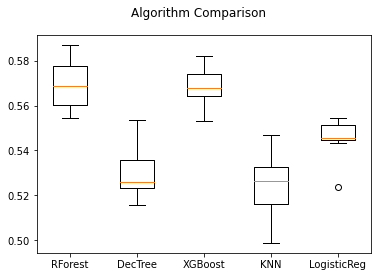

In [192]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Train/Test i feature_importances_ amb categòriques

Random Forest

In [193]:
rf = RandomForestClassifier()

In [194]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [195]:
rf_pred = rf.predict(X_test)

In [196]:
score_rf = rf.score(X_test, y_test)
print(score_rf)

0.56625


In [197]:
print(classification_report(y_test, rf_pred ))

              precision    recall  f1-score   support

           0       0.56      0.59      0.57      2000
           1       0.57      0.55      0.56      2000

    accuracy                           0.57      4000
   macro avg       0.57      0.57      0.57      4000
weighted avg       0.57      0.57      0.57      4000



In [198]:
i_col = (df_sample.drop([forecast_col], 1))

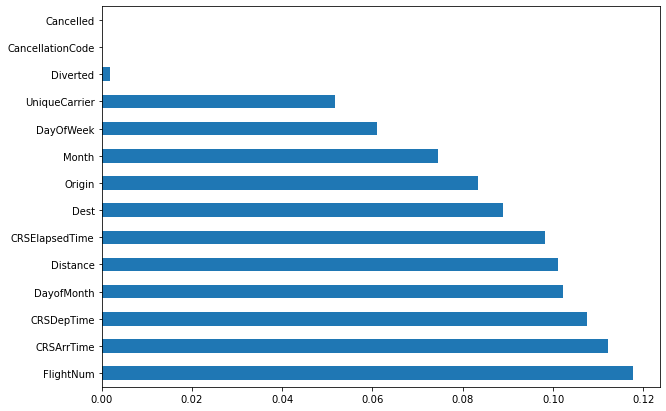

In [199]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(rf.feature_importances_, index = i_col.columns)
feat_importances.nlargest(15).plot(kind='barh');

Classification Tree 

In [200]:
ct = DecisionTreeClassifier()

In [201]:
ct = ct.fit(X_train,y_train)

In [202]:
ct_pred = ct.predict(X_test)

In [203]:
score_ct = ct.score(X_test, y_test)
print(score_ct)

0.5315


In [204]:
print(classification_report(y_test, ct_pred ))

              precision    recall  f1-score   support

           0       0.53      0.53      0.53      2000
           1       0.53      0.53      0.53      2000

    accuracy                           0.53      4000
   macro avg       0.53      0.53      0.53      4000
weighted avg       0.53      0.53      0.53      4000



In [205]:
i_col = (df_sample.drop([forecast_col], 1))

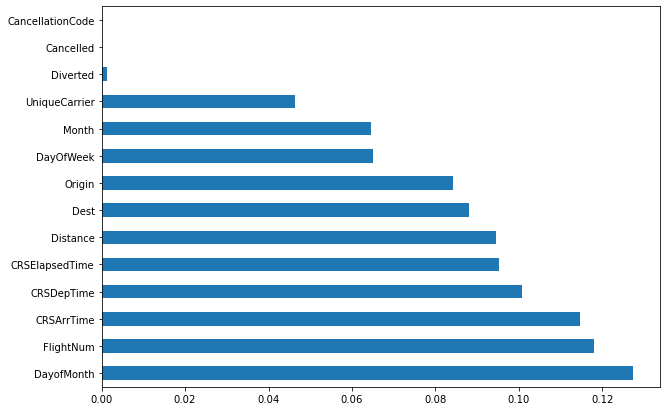

In [206]:
plt.figure(figsize=(10,7))
feat_importances = pd.Series(ct.feature_importances_, index = i_col.columns)
feat_importances.nlargest(15).plot(kind='barh');

#### Estratègies per Imabalance

In [273]:
df = pd.read_csv('DelayedFlights.csv')

In [274]:
df_1 = df

In [275]:
df_1.drop(['Unnamed: 0','UniqueCarrier','CancellationCode', 'Origin', 'Dest', 'TailNum', 'Year',
           'DepDelay', 'ArrTime', 'DepTime', 
           'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
            'AirTime', 'TaxiIn','TaxiOut', 'ActualElapsedTime',], axis=1, inplace=True)


In [276]:
for i in df_1.columns:
    df_1[i].fillna(df_1[i].median(), inplace = True)

Canviem la predicció dels vols que arribaran tard fent servir la variable 'Delayed'  com a (ArrDelay > 0) en comptes de (ArrDelay > 15) per tenir un target més desbalancejat.

In [277]:
df_1['Delayed'] = df_1['ArrDelay']>0
bool_cols = df_1.columns[df.dtypes == 'bool']
df_1[bool_cols] = df_1[bool_cols].replace({True: 'Yes', False: 'No'})

In [278]:
df_1['Delayed'].value_counts(normalize=True)

Yes    0.894176
No     0.105824
Name: Delayed, dtype: float64

Veiem que hi ha un important desequilibri entre les classes (90% d'endarrerits i 10% de no endarrerits). Provarem de dur a terme alguna tècnica per lidiar amb imbalanced data:

In [279]:
encoder = LabelEncoder()

df_1['Delayed'] = encoder.fit_transform(df['Delayed'])

In [280]:
df_1['Delayed'].value_counts(normalize = True)

1    0.894176
0    0.105824
Name: Delayed, dtype: float64

In [281]:
df_1.drop(['ArrDelay'], axis=1, inplace=True)

In [282]:
df_1.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,Distance,Cancelled,Diverted,Delayed
0,1,3,4,1955,2225,335,150.0,810,0,0,0
1,1,3,4,735,1000,3231,145.0,810,0,0,1
2,1,3,4,620,750,448,90.0,515,0,0,1
3,1,3,4,1755,1925,3920,90.0,515,0,0,1
4,1,3,4,1915,2110,378,115.0,688,0,0,1


In [283]:
forecast_col ='Delayed'

#### Oversample Minority Class:

In [218]:
forecast_col ='Delayed'

In [219]:
df_1['Delayed'].value_counts(normalize = True)

1    0.894176
0    0.105824
Name: Delayed, dtype: float64

In [220]:
df_1['Delayed'].value_counts()

1    1731802
0     204956
Name: Delayed, dtype: int64

In [221]:
# separem la minority i majority class
not_delayed = df_1[df_1['Delayed']==0]
delayed = df_1[df_1['Delayed']==1]

# upsample de la minoritària
not_delayed_upsampled = resample(not_delayed,
                          replace=True, # sample with replacement
                          n_samples=len(delayed), # match number in majority class
                          random_state=27) # reproducible results

# combinem les dues
upsampled = pd.concat([delayed, not_delayed_upsampled])

# mirem els nous valors de les classes
upsampled.Delayed.value_counts()

0    1731802
1    1731802
Name: Delayed, dtype: int64

Veiem la comparació de mida entre el df abans de fer l'oversampling i després:

In [222]:
df_1.shape

(1936758, 11)

In [223]:
upsampled.shape

(3463604, 11)

Agafem la mostra del nou set balancejat:

In [224]:
df_sample = upsampled.sample(20000, random_state = 0)
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [225]:
df_sample['Delayed'].value_counts()

0    10036
1     9964
Name: Delayed, dtype: int64

In [226]:
print('Null accuracy is equal to:',max(y_test.mean(), 1 - y_test.mean()))

Null accuracy is equal to: 0.5017499999999999


#### K-Fold i Cross_val_score amb upsampling

In [227]:

models = [('RForest', RandomForestClassifier()), 
          ('DecTree', DecisionTreeClassifier()),
          ('XGBoost', xgb.XGBClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LogisticReg', LogisticRegression())]
scoring = 'accuracy'

In [228]:
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    

RForest: 0.612375 (0.009980)
DecTree: 0.551250 (0.009618)
XGBoost: 0.607125 (0.009715)
KNN: 0.572875 (0.004802)
LogisticReg: 0.599187 (0.014502)


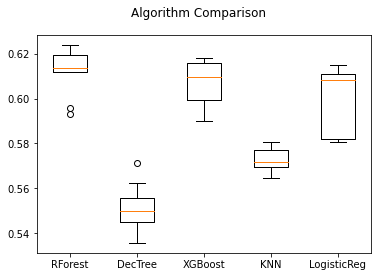

In [229]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Undersample Majority Class:

In [230]:
df_1['Delayed'].value_counts()

1    1731802
0     204956
Name: Delayed, dtype: int64

In [231]:
# separem la classe minoritària i la majoritària
not_delayed = df_1[df_1['Delayed']==0]
delayed = df_1[df_1['Delayed']==1]

# downsample de la majoritària
delayed_downsampled = resample(delayed,
                          replace=True, # sample with replacement
                          n_samples=len(not_delayed), # match number in majority class
                          random_state=27) # reproducible results

# combinem les dues
downsampled = pd.concat([delayed_downsampled, not_delayed])

# mirem els nous valors de les classes
downsampled.Delayed.value_counts()

0    204956
1    204956
Name: Delayed, dtype: int64

Comparem les mides del df amb undersample majority class:

In [232]:
df_1.shape

(1936758, 11)

In [233]:
downsampled.shape

(409912, 11)

Agafem la mostra del nou set balancejat:

In [234]:
df_sample = downsampled.sample(20000, random_state = 0)
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [235]:
print('Null accuracy is equal to:',max(y_test.mean(), 1 - y_test.mean()))

Null accuracy is equal to: 0.507


#### K-Fold i Cross_val_score amb downsampling

In [236]:

models = [('RForest', RandomForestClassifier()), 
          ('DecTree', DecisionTreeClassifier()),
          ('XGBoost', xgb.XGBClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LogisticReg', LogisticRegression())]
scoring = 'accuracy'

In [237]:
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    

RForest: 0.607750 (0.011549)
DecTree: 0.548625 (0.013540)
XGBoost: 0.608063 (0.011880)
KNN: 0.562250 (0.010775)
LogisticReg: 0.600812 (0.012279)


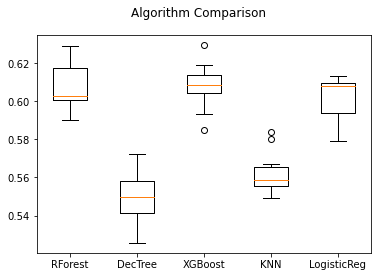

In [238]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Synthetic Minority Oversampling Technique (SMOTE):

In [239]:
df_1

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,Distance,Cancelled,Diverted,Delayed
0,1,3,4,1955,2225,335,150.0,810,0,0,0
1,1,3,4,735,1000,3231,145.0,810,0,0,1
2,1,3,4,620,750,448,90.0,515,0,0,1
3,1,3,4,1755,1925,3920,90.0,515,0,0,1
4,1,3,4,1915,2110,378,115.0,688,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1936753,12,13,6,1220,1552,1621,152.0,906,0,0,1
1936754,12,13,6,600,749,1631,109.0,481,0,0,1
1936755,12,13,6,847,1010,1631,143.0,689,0,0,1
1936756,12,13,6,1240,1437,1639,117.0,533,0,0,1


In [240]:
df_sample= df_1.sample(20000, random_state = 0)
X = (df_sample.drop([forecast_col], 1))
y = (df_sample[forecast_col])
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [241]:
df_1['Delayed'].value_counts(normalize=True)

1    0.894176
0    0.105824
Name: Delayed, dtype: float64

In [242]:
df_sample['Delayed'].value_counts(normalize=True)

1    0.898
0    0.102
Name: Delayed, dtype: float64

In [243]:
y_train.value_counts(normalize=True)

1    0.898
0    0.102
Name: Delayed, dtype: float64

In [244]:
counter = y_train.value_counts()
print('Before', counter)

sm = SMOTE(random_state=27)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

counter = y_train_sm.value_counts()
print('After', counter)

Before 1    14368
0     1632
Name: Delayed, dtype: int64
After 0    14368
1    14368
Name: Delayed, dtype: int64


In [245]:
y_train_sm.value_counts(normalize=True)

0    0.5
1    0.5
Name: Delayed, dtype: float64

In [246]:
print('Null accuracy is equal to:',max(y_test.mean(), 1 - y_test.mean()))

Null accuracy is equal to: 0.898


#### K-Fold i Cross_val_score amb smote

In [247]:
models = [('RForest', RandomForestClassifier()), 
          ('DecTree', DecisionTreeClassifier()),
          ('XGBoost', xgb.XGBClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LogisticReg', LogisticRegression())]
scoring = 'accuracy'

In [248]:
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train_sm, y_train_sm, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    

RForest: 0.945713 (0.001786)
DecTree: 0.874965 (0.006617)
XGBoost: 0.927025 (0.003387)
KNN: 0.838530 (0.005850)
LogisticReg: 0.596186 (0.005984)


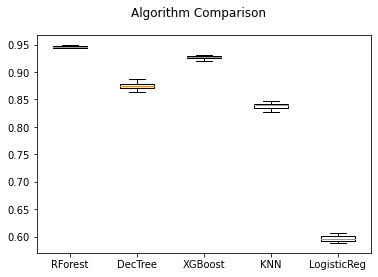

In [249]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

L'accuracy de les prediccions amb SMOTE ha augmentat molt però només perque el test estava molt desbalancejat. La null accuracy amb aquest test és de 89,8%, per tant encara que sembli que siguin molt bons models només estan una mica per sobre d'un 'dumb model'.  
Examinem mètriques més avançades fent servir el train d'SMOTE amb random forest:

Random Forest amb SMOTE

In [250]:
rf = RandomForestClassifier()

In [251]:
rf.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [252]:
rf_pred = rf.predict(X_test)

In [253]:
score_rf = rf.score(X_test, y_test)
print(score_rf)

0.87025


In [254]:
print(classification_report(y_test, rf_pred ))

              precision    recall  f1-score   support

           0       0.18      0.07      0.10       408
           1       0.90      0.96      0.93      3592

    accuracy                           0.87      4000
   macro avg       0.54      0.52      0.52      4000
weighted avg       0.83      0.87      0.85      4000



In [255]:
confusion = metrics.confusion_matrix(y_test, rf_pred)
print(confusion)

[[  30  378]
 [ 141 3451]]


Com veiem l'algoritme té una accuracy molt alta perquè gairebé prediu totes les instàncies com a delayed. En canvi, el macro avg. de l'F1-score és de 0.5

### Extres: divisió dels enderreriments en 4 classes i PCA per KNN

#### KNN amb PCA

In [284]:
df_sample= df_1.groupby('Delayed', group_keys=False).apply(lambda x: x.sample(10000, random_state = 0))
X = np.array(df_sample.drop([forecast_col], 1))
y = np.array(df_sample[forecast_col])
X = StandardScaler().fit_transform(X)

In [285]:
# Fem el PCA:

pca = PCA(n_components=3)
X = pca.fit_transform(X)

print('La variància de cada un dels components seleccionats és:',pca.explained_variance_ratio_) # Treiem els variance ratio del número de components seleccionats
print('La suma de la variància de tots els components seleccionats:',pca.explained_variance_ratio_.sum()) # Sumem el variance ratio per veure quanta informació treiem amb el número de PCA

La variància de cada un dels components seleccionats és: [0.22114008 0.16563452 0.10658578]
La suma de la variància de tots els components seleccionats: 0.4933603750494106


In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

K-Nearest Neighbours

In [287]:
knn = KNeighborsClassifier()

In [288]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [289]:
knn_pred = knn.predict(X_test)

In [290]:
score_knn = knn.score(X_test, y_test)
print(score_knn)

0.551


In [291]:
print(classification_report(y_test, knn_pred ))

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      2000
           1       0.55      0.55      0.55      2000

    accuracy                           0.55      4000
   macro avg       0.55      0.55      0.55      4000
weighted avg       0.55      0.55      0.55      4000



#### Divisió de l'enderreriment en 4 classes

In [256]:
df = pd.read_csv('DelayedFlights.csv')

In [257]:
df_1 = df

In [258]:
df_1.drop(['Unnamed: 0','UniqueCarrier','CancellationCode', 'Origin', 'Dest', 'TailNum', 'Year',
           'DepDelay', 'ArrTime', 'DepTime', 
           'CarrierDelay', 'WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 
            'AirTime', 'TaxiIn','TaxiOut', 'ActualElapsedTime',], axis=1, inplace=True)


In [259]:
for i in df_1.columns:
    df_1[i].fillna(df_1[i].median(), inplace = True)

Dividim els enderreriments en 4 classes (qcut = 4):

In [260]:
# Dividim les dades continues en 4 'cistelles' per agrupar-les en 4 grups, segons els quartiles:
df_1['ArrDelay'] = pd.qcut(df_1['ArrDelay'], q=4)

In [261]:
# Veiem la divisio del pd.qcut. Tenim 4 bins
df_1['ArrDelay'].value_counts()

(-109.001, 9.0]    506623
(55.0, 2461.0]     484049
(24.0, 55.0]       478878
(9.0, 24.0]        467208
Name: ArrDelay, dtype: int64

El temps d'arrivada (enderreriment) queda dividit així en 4 grups o classes:  

- Entre -109.001, i 9.0 min  
- Entre 9.0 i 24.0 min       
- Entre 24.0 i 55.0 min         
- Entre 55.0, i 2461.0 min    



In [262]:
encoder = LabelEncoder()

df_1['ArrDelay'] = encoder.fit_transform(df_1['ArrDelay'])

df_1.head()

,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,FlightNum,CRSElapsedTime,ArrDelay,Distance,Cancelled,Diverted
0,1,3,4,1955,2225,335,150.0,0,810,0,0
1,1,3,4,735,1000,3231,145.0,0,810,0,0
2,1,3,4,620,750,448,90.0,1,515,0,0
3,1,3,4,1755,1925,3920,90.0,2,515,0,0
4,1,3,4,1915,2110,378,115.0,1,688,0,0


In [263]:
df_1['ArrDelay'].value_counts()

0    506623
3    484049
2    478878
1    467208
Name: ArrDelay, dtype: int64

In [264]:
forecast_col ='ArrDelay'

In [268]:
# Agafem una mostra més petita pel cost computacional:
df_sample= df_1.groupby('ArrDelay', group_keys=False).apply(lambda x: x.sample(2500, random_state = 0))
X = (df_sample.drop([forecast_col], 1))
y = (df_sample[forecast_col])
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

#### K-Fold i Cross_val_score amb 4 classes

In [269]:
models = [('RForest', RandomForestClassifier()), 
          ('DecTree', DecisionTreeClassifier()),
          ('XGBoost', xgb.XGBClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('LogisticReg', LogisticRegression())]
scoring = 'accuracy'

In [270]:
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=2, shuffle = True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    

RForest: 0.296375 (0.009802)
DecTree: 0.261500 (0.010515)
XGBoost: 0.300250 (0.013883)
KNN: 0.272500 (0.013205)
LogisticReg: 0.309500 (0.016184)


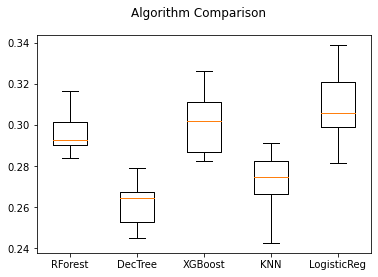

In [271]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Conclusions:
- Hem aconseguit una accuracy del 0.62 amb upsampling i random forest tenint una null accuracy igual que la inicial (0.5).
- Aquest no és un bon dataset per fer PCA ja que la seva variabilitat és dificil de captar amb pocs components.
- Les prediccions amb 4 graus d'endarreriment encara es fan més complicades. Amb prou feines es supera un 30% d'accuracy (XGBoost 32%). 

### Conclusions finals

Creiem que l'espai més gran de millora de tots els models es troba en la creació de features. Per les circumstàncies del problema hem decidit que no tenia massa sentit intentar trobar-ne de nous quan des d'un principi podiem tenir uns models amb una performance gairebé perfecte en cas de no eliminar certes variables. D'altra banda aquesta selecció fa insuficient la capacitat predictiva dels models, ja que amb prou feines superen les d'un 'dumb model'. 

Hem trobat espais de millora més reduits en relació a l'hyperparameter tunning i la inclusió de les variables categòriques fent LabelEncoder. Caldria estudiar millor quines variables poden entrar i quines no, per trobar un entremig tal que els models no tinguin marge de millora, ni que les solucions no estiguin en els features.